# Preprocessing

Pandas를 사용하여 정형 데이터를 다루는 방법을 설명한다.
 - Category Data를 변경
 - Null값 처리
 - 범주화 방법 안내



## 타이타닉 데이터


Data Dictionary

 - Variable Definition	Key
 - survival	Survival	0 = No, 1 = Yes
 - pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
 - sex	Sex	
 - Age	Age in years	
 - sibsp	# of siblings / spouses aboard the Titanic	
 - parch	# of parents / children aboard the Titanic	
 - ticket	Ticket number	
 - fare	Passenger fare	
 - cabin	Cabin number	
 - embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton 



In [4]:
# Load in our libraries
import pandas as pd #http://pandas.pydata.org/ #Python Data Analysis Library 
import numpy as np #NumPy is the fundamental package for scientific computing with Python. It contains among other thing
import re #정규식
import sklearn # http://scikit-learn.org/stable/ Simple and efficient tools for data mining and data analysis
import xgboost as xgb # Scalable and Flexible Gradient Boosting https://xgboost.readthedocs.io/en/latest/
import seaborn as sns  # https://seaborn.pydata.org/   seaborn: statistical data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py  #Visualize Data, Togethe #https://plot.ly/
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
# Load in the train and test datasets
train = pd.read_csv('./data/titanic/train.csv')
test = pd.read_csv('./data/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

# Titanic Data 설명
 - https://www.kaggle.com/c/titanic
 
사람 이름도 있고, 성별도 있고, Ticket 번호도 있고, 요금도 있고, 객실번호도 있고, 어느 항구에서 배를 탔는지도 있고
다양한 조건이 다양하게 들어가 있음.
이 데이터를 전처리 해야함

In [3]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## 1) Name, cabin Feature Engneering
 - name은 길이로 변환
 - cabin은 값이 있으면 1, 없으면 0으로 바꿔서 has_cabin으로 변경

In [6]:
#kaggle Data는 train과 test를 분리해서 주기 때문에 일단 list에 DataFrame을 넣어 놓는다.
full_data = [train, test]
print('train row {0}'.format(len(train.index)))
print('test row {0}'.format(len(test.index)))


# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
#print(train['Name_length'])

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

print(train['Has_Cabin'].head(10))


train row 891
test row 418
0    0
1    1
2    0
3    1
4    0
5    0
6    1
7    0
8    0
9    0
Name: Has_Cabin, dtype: int64


## 2) SibSp, Parch Feature Engneering(친적, 부모자식)
 - 친적과, 부모, 자식을 합쳐서 FamilySize로 변경
 - FamilySize가 1이면 1이고, 아니면 0인 IsAlone 컬럼 만듬

In [7]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch

#새로운 Feature를 만듭니다.(친척과 자식)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
# IsAlone이 Feature를 새로 만든다.
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    #print(dataset['IsAlone'])
    

## 3) Embarked, Fare Feature Engneering(친적, 부모자식)
 - 항구의 null 값을 'S'로 바꿈
 - Fare의 Null값은 median(중앙값)으로 바꿈
 - Fare를 pd.qcut(train['Fare'], 4) 갯수를 기준으로 4단계로 바꿈
 - Categories (4, object): [[0, 7.91] < (7.91, 14.454] < (14.454, 31] < (31, 512.329]]

In [8]:
# Nan값을 S로 치환한다.
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# Nan값을 평균값으로 취소한다.
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print(train['CategoricalFare'].values)
# Create a New feature CategoricalAge
# qcut는 같은 갯수로 나눔
# cut은 실수값의 경계선으로 자름

[[0, 7.91], (31, 512.329], (7.91, 14.454], (31, 512.329], (7.91, 14.454], ..., (7.91, 14.454], (14.454, 31], (14.454, 31], (14.454, 31], [0, 7.91]]
Length: 891
Categories (4, object): [[0, 7.91] < (7.91, 14.454] < (14.454, 31] < (31, 512.329]]


## 4) Age Null 값 처리 및 Age를 Category화
 - Age의 평균 구하고, 표준편차 구하고, Null 값의 갯수를 구한다음
 - 랜덤 Int를 생성하는데 평균에서 편차 빼고것부터 평균에서 편차를 더한것 범위에서 Null의 갯수만큼
 - np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
 - Age의 Null 값을 Update
 - pd.cut(train['Age'], 5) 실수 기반으로 5단계로 바꿈


In [10]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()   # 평균
    age_std = dataset['Age'].std()    # 표준편차 구하기 : 분산의 제곱근
    age_null_count = dataset['Age'].isnull().sum()
    print("start random age {0}".format(age_avg - age_std))
    print("end random age {0}".format(age_avg + age_std))
    
    #nan값을 처리 하는 로직.
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
print(pd.cut(train['Age'], 5).values)

start random age 16.006047086870048
end random age 43.20607412525116
start random age 16.706933567946372
end random age 43.13038700621631
[(16, 32], (32, 48], (16, 32], (32, 48], (32, 48], ..., (16, 32], (16, 32], (32, 48], (16, 32], (16, 32]]
Length: 891
Categories (5, object): [(-0.08, 16] < (16, 32] < (32, 48] < (48, 64] < (64, 80]]


## 5) Name 전처리
- 정규식을 사용해서 Mr. Miss Mrs 를 추출함.

In [11]:
# 정규식을 통해서 Lady.Dr Major등을 추출함
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

print(get_title('Cumings, Mrs. John Bradley (Florence Briggs Th...'))

Mrs


In [12]:
# Title 컬럼 생성
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(dataset['Title'].head(3) )

0     Mr
1    Mrs
2     Mr
Name: Title, dtype: object


## 6) Sex, Title, Fare범주화, Age 범주화
- 출발항구도 숫자로 변경
- 위에서 계산된 범위를 가지고 Fare와 Age를 범주화함

In [13]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

print(train['Title'].head(3))
print(train['Embarked'].head(3))
print(train['Fare'].head(3))

0    1
1    3
2    2
Name: Title, dtype: int64
0    0
1    1
2    0
Name: Embarked, dtype: int64
0    0
1    3
2    1
Name: Fare, dtype: int64


## 7) 변경 완료된 Feature들 제거
- 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp' 제거

In [15]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [16]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


## 7) 상관관계를 살펴보자
. 점수가 높은것들은 제거가 필요함

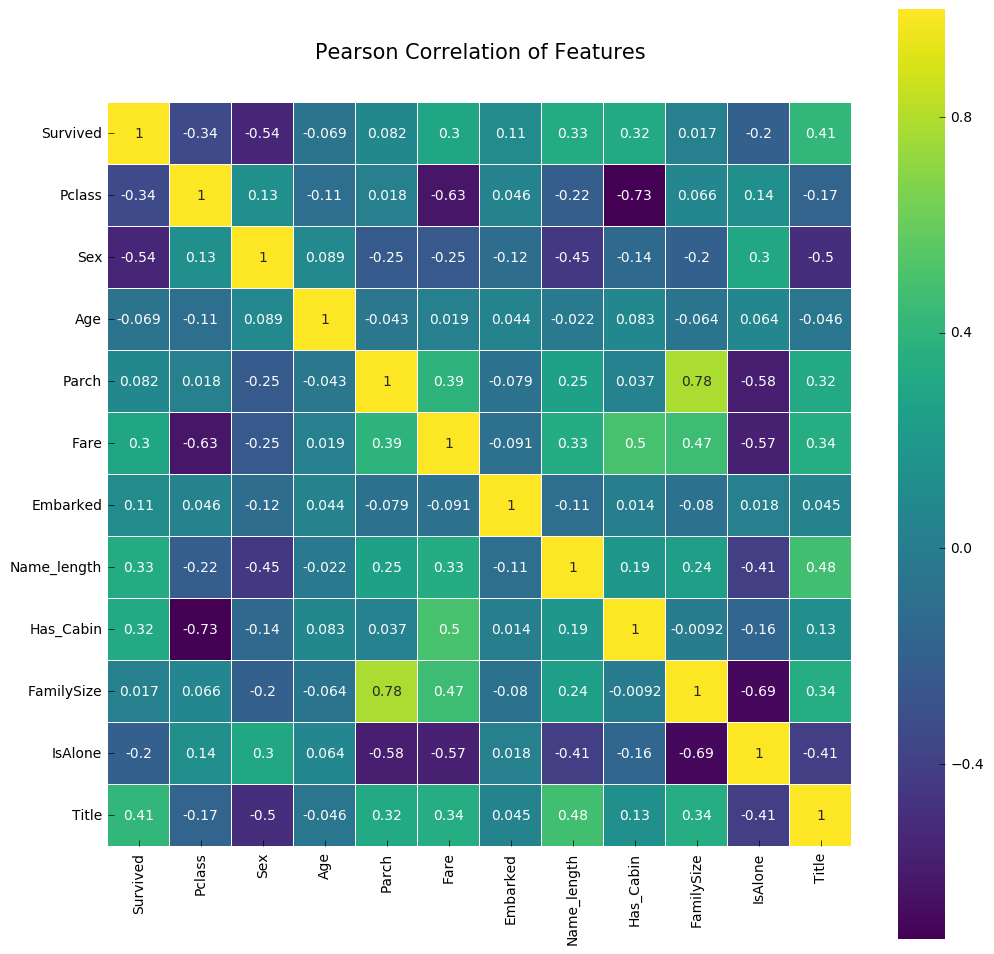

In [13]:
#상관관계를 살펴보자.
# Pandas에서 corr()를 통해서 상관계수를 알수 있다.
# 1, -1에 가까울수록 양과 음의 선형관계를 갖는다.
# 0이면 선형관계가 없다.
# 아래에서 Parch와 Failimy size가 상관관계가 높다.
# 각변수들 간에 중복되거나 불필요한 정보가 없다.


colormap = plt.cm.viridis #color map 생성
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
#print(train.astype(float).corr())
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

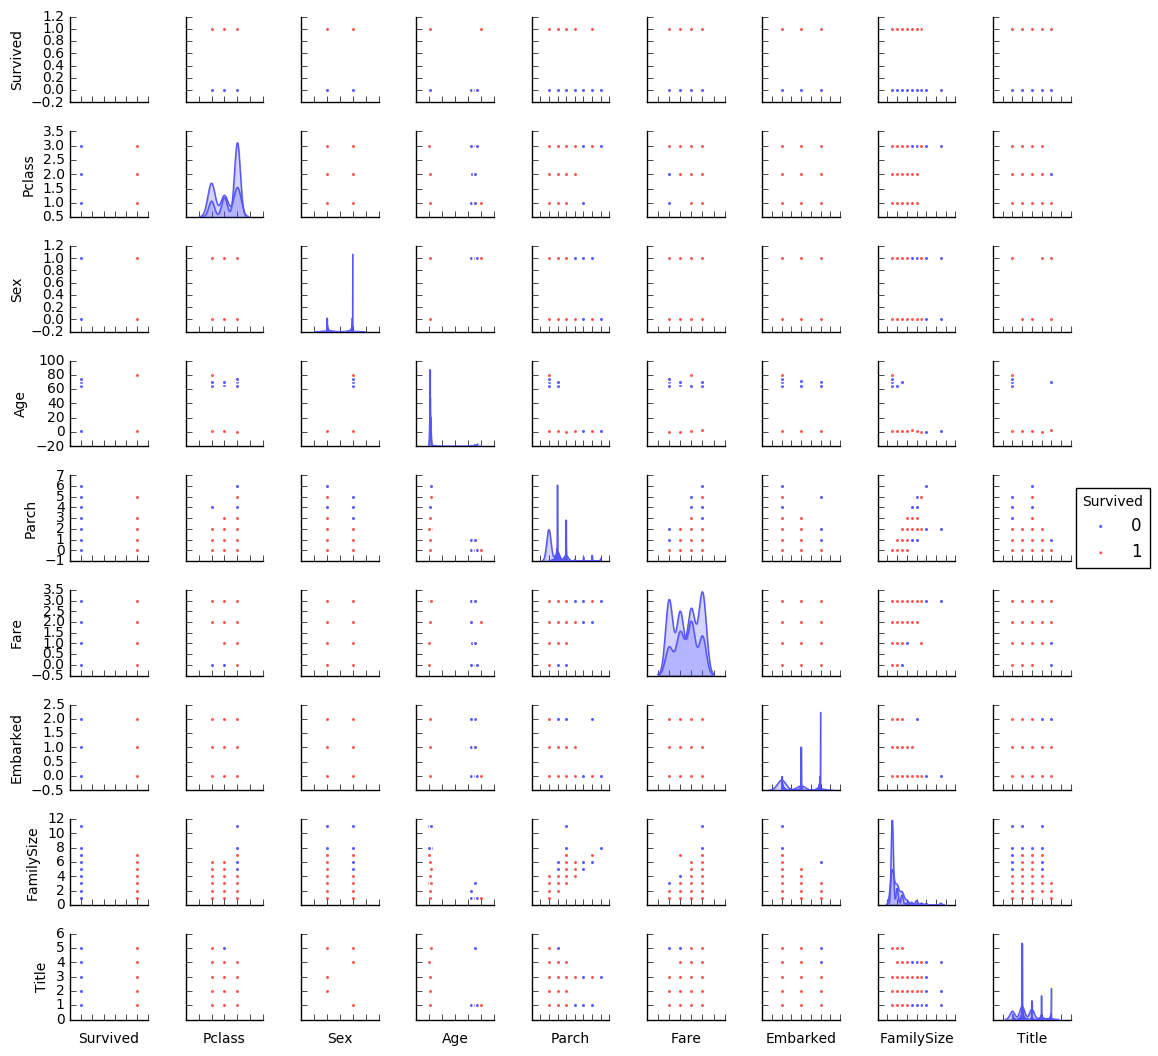

In [17]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])